# Introduction



# Model: WeightedCA 

The WeightedCA model builds off of the WCA2D model (Guidolin et al., 2016) to simulate flooding over surface terrain using a 2D CA and weight-based transition rules. The model is quasi-physical, solving simple shallow-water equations while using a weighting system to speed up the simulation. 

The pseudocode is as follows:

```python
init grid, layers

each time step: 
    for i in range(N):
        for j in range(N):
            central_cell = grid[i,j]

            find downstream cells relative to central_cells

            compute total available storage volume v_tot
            compute the weight of each cell using v_tot
            compute IC volume using weights ic

            update cell states
                remove ic from central cell water level
                add weight*ic to downstream cells level
```

The terms are fairly esoteric, and are better explained by specifying the model and demonstration with toy examples. 

## Cells

The model takes a Digital Elevation Model, stored as a numpy array, as input. For an `(N,N)` input, the preprocessing stage involves the addition of 4 layers to an expanded shape of `(N,N,5)`:

1. Layer 1: Ground Level. 

    This layer is the DEM itself, with no_data values (e.g. -9999) masked out. A DEM represents surface terrain of a landscape using a grid comprising cells, where each cell has a raster size of, say, `30m x 30m`. Data was downloaded using, in one-off excellence for a `.gov` website, [EarthExplorer](https://earthexplorer.usgs.gov/) and converted to a numpy array using the `geotiff` module. 

    (Figure. Resampling a large DEM: the southern Western Ghats, India)[]
    
    For simulating very large cachements `(>10,000, >10,000)`, the DEM could be resampled using the `resample_array` utility to a more computationally tractable smaller grid size, while retaining the overall topology. As seen in the figure above, however, aggressive resampling creates sheer drops between adjacent cells, which we almost never find in real-world data. 

2. Layer 2: Water Columns.

    This layer records the water level of each cell, relative to Ground (DEM) Level. This is the state we will update each time step in the CA. The layer can be initialized to dry cells (i.e. all cells with a water level of 0), or pre-exisitng water levels. Precipitation can be thought of making minor additions to this layer each time step. 

3. Layer 3: Slope Field. 

    This records the slope (degrees) of each cell. It measured by considering the Moore neighborhood of each cell, measuring the change along the `row` and `column` directions of the 3x3 window. The slope field can be thought of as cached data to help calculate Manning flow in the transition rules.  

4. Layer 4: Directions. 

    (Figure. Direction Codes for Downstream Neighbors.)

    This records the **directions** of flow for each cell, encoded as an integer between `[0, 255]`. Water in a cell may flow to any of 8 neighboring cells, as long as they are downstream. As such, to find the directions for each cell, we first find the downstream cells, and encode each of their positions in binary. For example, a cell with no downstream neighbors would be stored as `[00000000] = 0`, while a cell with a downstream neighbor in the North and West would be stored as `[00001010] = 10`.  

5. Layer 5: Previous Intercellular Volume. 

    The previous intercellular volumes for each cell are stored here. At the start of the simulation, this is initialized to 0. This layer is needed to compute the intercellular flow at time step `t+ \Delta t`. 

    These terms will be explained in the next section on transition rules.



## State Transition Rules

We are interested in updating the water height of a central cell $d_c$ at time $t + \Delta t$ considering the state of the central cell and its neighbors at time $t$, where $\Delta t$ is a simulation parameter. We first consider the height differences between a central cell $c$ and each of its neighbors $i$,   

$$ \Delta d_{c,i} = d_c - d_i      \hspace{2cm}   \forall i \in \{1 \cdots 8\} $$

$d$ ($m$) is the water *height* at a given cell. The water height is the sum of a cell's elevation and its water column $w_c$ at time $t$. Since elevation is recalled from a DEM, measured as meters from mean sea level, this can also be thought of as the water level relative to mean sea level. As such, $\Delta d_{c,i}$ measures the height difference between water levels in the central cell $c$ and its neigbour $i$. 

$$ \Delta V_{c,i} = A \: \text{max}(\Delta d_{c,i}, 0) \hspace{1cm}   \forall i \in \{1 \cdots 8\} $$

$A$ ($m^2$) is the area of each cell. This is a constant, as each cell in the grid is a square with length ($l$) equal to the resolution of the DEM. Typical raster sizes are (10x10) ($m^2$) or (30x30) ($m^2$).

$\Delta V_{c,i} $  ($m^3$) calculates the volume we need to add to cell ${i}$ such that the water levels between the central cell and the cell $i$ are balanced. Implicating mass conservation, this is the available storage volume for the cell $i$. 

$$ \Delta V_{\text{tot}} = \sum_{i=1}^8 \Delta V_{c,i} $$

$\Delta V_{tot}$  ($m^3$) sums over all $\Delta V_{c,i}$ to yield the total available storage volume across all neighbors. The largest contribution to this term will come from the largest $\Delta V_{c,i}$. Since area is constant, this coincides with the lowest downstream neighbor or, equivalently, the neighbor with the largest height difference with the central cell. We will make use of this fact in the weighting system, an algorithm for determining flow proportions to downstream neighbors. 




Consider a simple physical intuition: when water flows downstream, it chooses the path of least resistance. This rules out water flowing upwards (as it loses energy in the process), so an efficient path must be one of steepest descent. In continous space, we have a wide span of directions to choose for this path. In a CA, however, we have discretized all possible paths into a finite set of (8) directions. To compensate for this loss of granularity, we don't consider a *single* path for the flow, but rather, a series of flow proportions to downstream neighbors. These flow proportions are such that the steepest downstream neighbor receives the largest fraction, while the remaining neighbors receive smaller and smaller fractions in proportion to their lower and lower steepness. In the simplest case, consider the following height differences across 8 neighbors `[0,10,0,5,0,5,0,0]`. The flow proportions are `[0,0.5,0,0.25,0,0.25,0,0]`.

$$ w_i = \frac{\Delta V_{c,i}}{\Delta V_{\text{tot}} + \Delta V_{\text{min}}} , w_c = \frac{\Delta V_{\text{min}}}{\Delta V_{\text{tot}} + \Delta V_{\text{min}}}  $$

In this formulation, downstream neigbours may reach heights above the central cell, which causes oscillations in the simulation (Guidolin et al., 2016). To minimize these, we permit the central cell retain a fraction of the total volume, $\Delta V_{\text{min}}$, the minimum available volume found in neigbours. Unlike the Guidolin et al. formulation, we also set a minimum volume of (1e-4) and maximum volume (1e4) in the event that no downstream neighbor is found. This was found to reduce oscillations in the simulation dramatically.

While the weighting system alone can serve as a simple, "water balancing" transition rule, it excludes physical terms that might improve the modeling of flood dynamics. For example, there are flooding regimes where a small, local area will experience a large influx of water and become completely indundated, before the water dissipates after a short interval of time. To introduce these terms, we introduce a new quantity, total intercellular volume $ I_{\text{tot}}$ $(m^3)$. In constrast to total available storage volume, total intercellular volume is the total outflow from the central cell over the timestep $\Delta{t}$ and must strictly be $ I_{\text{tot}} < \Delta V_{\text{tot}} $,

$$ I_{\text{tot}}^{t + \Delta t} =  \text{min} (d_c A ,  \frac{I_M}{w_M} , \Delta V_{\text{min}} + I_{\text{tot}}^ t) $$



Of the three terms, the first one is a simple limitation: the outflow cannot exceed the total available volume in the cell  ($d_c A_c$). The third term is an 'inertial' volume: we consider the transfer out of the cell in the previous iteration, and add the volume that would be transferred out of the central cell. The second term represents the maximum possible intercellular volume $I_M$, which flows into the downstream neighbor with the largest weight $w_M$,

$$ I_M = v_M d_c l \Delta t  $$


Here, ($v_M d_c l$) ($m^3 / s$) computes the maximum permissible volume change in a second. $l$ is the cell length ($m$), $d_c$ is the water height ($m$), and $v_M$ is the maximum permissble velocity ($m / s$) at the current time step. $\Delta t$ (s) is the time step, which is a simulation parameter.

$$ v_M = \text{min} ( \sqrt{2 g d_c} , \frac{1}{n} d_c^{\frac{2}{3}} \sqrt{\frac{\Delta d_{c,M} }{l}}) $$



To calculate the maximum permissible velocity, we consider a maximum theoretical velocity term $\sqrt{2d_c g}$, when water is theoretically in free fall: all its stationary Gravitational Potential Energy is converted to Kinetic Energy $(mgh = 1/2 mv^2 ; 2gh = v^2 ; \sqrt{2gh} = v)$. The next term is Manning's formula, an estimation for average velocity of a liquid flowing in an open channel. $\sqrt{\frac{\Delta d_{c,M} }{l}}$ computes the gradient (-) between the central cell height, while $d_c$ is the height of the water column in the central cell. $n$ is Manning's coefficient, which is set to 0.02, the value often used for floodplain simulations over smooth earth. 


Tying everything together, we can update water columns using the following equations:

$$ d_{c}^{t + \Delta t} = d_c^t - \frac{I_{tot}^{t + \Delta t}}{A} $$

First for the central cell's water column, we simply subtract out the total intercellular volume divided by the cell area.

$$ d_{i}^{t + \Delta t} = d_i^t - \frac{ w_i  I_{tot}^{t + \Delta t}}{A}  \hspace{1cm} \forall i \in \{1 \cdots 8\}$$

Then, for the neighbors, we subtract out the flow proportion times the total intercellular volume, divided by the cell area. The model neglects outflows due to infiltration in the interest of simplicity. 

## Benchmark Model: Flow-Accumulation Matrix 

While we have good intuitions about how water flows in small cases (see Toy Examples, below), we need another heuristic for how well the simulation will work in larger cases. To do so, we estimate a flow accumulation matrix. 

Unlike the CA, this simulation does not have a time component, and does not solve any equations. Instead, we are using information from the Direction Layer to suppose where water would end up. We do this by repeatedly asking a unit of water to flow down terrain, and tally the cells it passes through:

```python
def make_flow_acc(grid, limit = 10, iterations = 10000):
    
    let N be the number of rows/columns in the grid
    Initialize flow accumulation matrix Fa = (N,N)

    for i in range(iterations):
        let grid[i,j] be a randomly selected current_cell in grid

        visit the cell in Fa matrix Fa[i,j] += 1
        initialize visited_cells to 1

        while visited_cells < limit:
            get the direction vector of the cell c[i,j, 2]
            unpack the direction vector to a list of directions
            select a random direction from the list of directions (dx, dy)

            update the current_cell to the chosen direction grid[i + dx, j + dy] += 1
            visit the cell in Fa matrix Fa[i + dx, j + dy] += 1

    return Fa
```

Recall that a direction code [0-255] stores upto 8 possible downstream directions. In `make_flow_acc`, the next visit is chosen at random, making this simulation stochastic.

(Figure . Flow Accumulation for basin)
(Figure. Flow Accumulation for penrose)

While the visualization of the flow accumulation matrix is seemingly equivalent to the height map in simple examples, it is much more useful for complex terrains. Additionally, it can be used to simulate local patterns of rainfall. 

(Figure. Flow Accumulation for basin with local rainfall)



## Metrics

Toy Model 1. Basin Model. $\Delta t$ = 60s.
Toy Model 2. Dam-Basin Model. $\Delta t$ = 60s

To ground the discussion of metrics, we will refer to two toy models: the Basin Model and the Dam-Basin Model. 

1. Total Mass ($m^3$).

    This metric primarily checks that the total mass is conserved across iterations of a simulation with no rainfall. When we simulate with rainfall, this metric proxies for a cumulative precipitation record. The units are a misnomer, as we technically need to rescale this by density (1000 $kg/m^3$) to get the correct units (in $kg$).

2. Average Flow Rate ($m^3/s$).

    This metric averages the intercellular volumes across each cell each iteration of the simulation. It answers the question: "How fast is the water flowing at the current iteration of the simulation?". Realizing this metric is the main benefit of adding physical terms to the model: along with inundation risk, we can also estimate the risk of flash flooding. 

    A shortcoming of the CA approach is that this metric is prone to oscillations, as small amounts of water pass back and forth between neighbors in the stable regime. To limit these oscillations, we have set minimium and maximum volumes (`v_min` and `v_max`) to `1e-4` and `1e4` respectively. 

3. Fraction of Cells Flooded [0,1].

    This metric measures the fraction of cells that are flooded according to a set of threholds (by default, this is `[0.1m, 0.5m, 1.0m]`). This allows us to estimate the risk of inundation at different levels of severity. 

4. Central Cell(s).  

    Records the total height of the water column at a cell/cells of interest across each iteration in the simulation. By default, this is the cell with position [5,5]. In simulating with the study cachement, we will choose areas of importance (points with arterial highways, high-denisty housing etc.). 

## Implementation 

The WeightedCA model was implemented in Python primarly using numpy. Optimizations were won using the `numba` package's jit compiler for especially expensive routines. Simulation performance statistics were saved in the `pref_resuls.txt` file. A suite of tests were implemented in Tests.ipynb, greatly benefitting from plotting utilities in `plotting_utils.py` and functional programming, which allowed tests to be performed on small, predictable cases. 

As a performance thumb rule, to simulate a `100x100` grid with `60*12 = 720` iterations and a `60`s timestep (a full rainy day), the model takes an average of about `140s` to run. While this is reasonably efficient, it is suboptimal for large grids and necessitates grid resampling, seen above. 

# Case Study: Kerala, India

World-wide SRTM database, with a 3-arc second resolution (`90m x 90m`). The overall study area is 108 km x 108 km, but we reduce this to `72 km x 54 km` to focus on inland areas more prone to flooding. Post-resampling, each cell has a size of `720m x 720m`. This introduces a new tradeoff: as we simulate larger areas, we lose out on possible targeted interventions. The [Hoover Dam](https://www.maverickhelicopter.com/hoover-dam-facts.aspx), for instance, stretches only 380m  or about half the length of a cell. In the interest of demonstrating how an intervention *can* be simulated using this model, we will construct damns of widths 5 cells long

## Rainfall Distribution

Using average weather data, we can estimate the distribution of rainfall in the region.

Assumes an average distribution over the entire region, as opposed to a more realistic distribution over localities, where some receive higher rainfall and some lower. 

## Simulation

params


reflection

### Rainfall

### Rainfall and Dam



## Results & Discussion

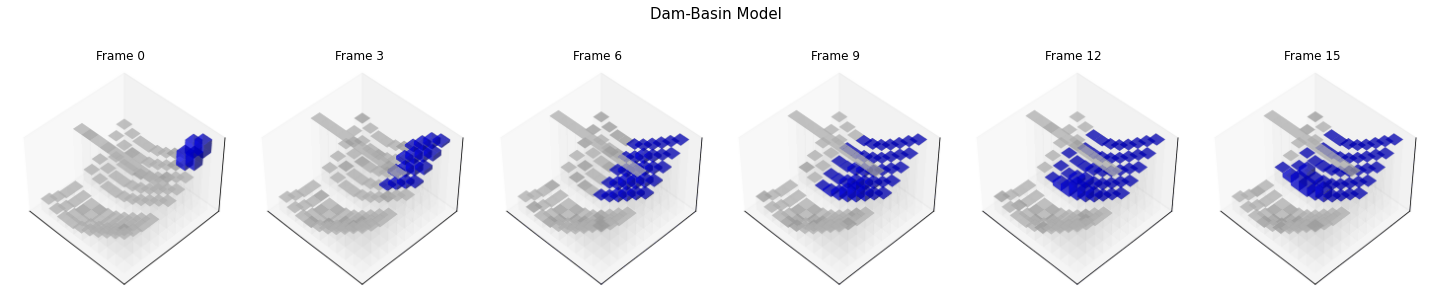

In [53]:
from PIL import Image
import matplotlib.pyplot as plt


basin = './media/dam_sim.gif'

# extract frames from the animation
frames = []
with Image.open(basin) as img:
    for i in range(img.n_frames):
        img.seek(i)
        # crop img
        frames.append(img.copy())

# crop each img in frames
for i, frame in enumerate(frames):
    pass
    #fr = frame.crop((100, 50, 0.75*frame.width, 0.85*frame.height))
    #frames[i] = fr
    

fig,axs = plt.subplots(1,len(frames)//2,figsize=(20,5))
# plot every other frame
for i,ax in enumerate(axs.flat):
    ax.imshow(frames[i*2].convert('RGB'))
    ax.set_title('Frame {}'.format(i*3))
    ax.axis('off')
    # reduce padding

# reduce gap between subplots to 0
fig.tight_layout()


# Set overall title
fig.suptitle('Dam-Basin Model',fontsize=15)

# save high res
fig.savefig('./media/dambasin_animation.png',dpi=300)

# References

1. Coppola, E., et al. (2007). Cellular automata algorithms for drainage network extraction and rainfall data assimilation.
    + Calculating the direction of flow is hard.
        + Start: minimum energy principle, choose the direction corresponding to the maximum slope (ie lowest cell in neighborhood)
        + However, "singularities due to finite resolution" at pits (where all 8 cells share the same height)  or flat zones (sequences of cells with same elevation)
        + CA2CHYM better than D8
        + smooths DEM (heights)
            x += sum(neighbors)/sum(distances = r)

2. Michele Guidolin et al. (2016). A weighted cellular automata 2D inundation model for rapid flood analysis.
    + The WCA2D model (which this builds on) is a diffusive-like model that **ignores inertia terms and momentum conservation**. It is designed to be as fast as possible for large-scale cachements.
    + The ratios of water transferred from the central cell to the downstream neighbour cells (intercellular-volume) are calculated using a quick weight-based system
    + The volume of water transferred between the central cell andthe neighbour cells is limited by the Manning's formula and the critical flow equation
    + Both the **adaptive time step** and the velocity are evaluated within a larger updated time step to speed up the simulation.
 
3. Cirbus, J., Podhoranyi, M. (2013). Cellular Automata for the Flow Simulations on the Earth Surface, Optimization Computation Process
    + The paper suggests that it uses the D8 model for flow direction (pick the **D**irection of the **8** neighbors with the lowest elevation). However, when I replicated Figure 3 in the paper, I found that it was instead doing a "pick the sum of the directions of all lowest neighbors" technique, which I haven't seen in similar papers. 
    + There was a miscalculation in the slope field. I corrected this and tested my calculations against a DEM-manipulation package, and got exactly the same results. 
    + Nonetheless, I have so much concern about the update rules and how they are defined. Each iteration, and each cell, the water in the cell changes by (water in from neighbors [to whom the central cell is the D8 neighbor]) - (water out to D8 neighbor). There is an idea about transfers happening in 'active cells' in the control flow diagram, but there is no mention of what makes a cell active in the rest of the paper. 
    + I don't understand how things are reconciled, in terms of flooded cells. This was vague. 

4. Working with Rasters
    +https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/reproject-raster/
    +https://rasterio.readthedocs.io/en/latest/topics/reproject.html

5. Flow Methods
    + https://richdem.readthedocs.io/en/latest/flow_metrics.html

6. Slope Calculation 
    + https://geol260.academic.wlu.edu/course-notes/digital-terrain-analyses/digital-terrain-analysis-3/
    + Barnes, Richard. 2016. RichDEM: Terrain Analysis Software. http://github.com/r-barnes/richdem